# 探索的データ解析
## ライブラリのインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
# 自作ライブラリのインポートを行うために、パスを通す
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
# 前処理関数
from util.preprocess import image_scaler

# 可視化
from util.visualize import show_image

# データの可視化
from util.load_datasets import load_all_datasets


## データの可視化

In [2]:
# データの読み込み
X_train, y_train, X_test = load_all_datasets()

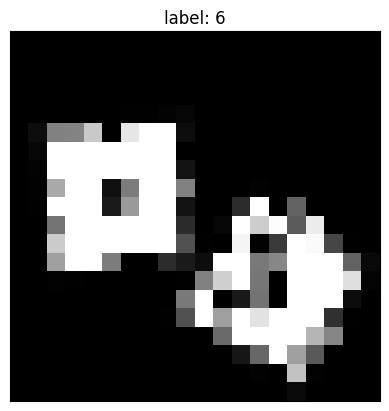

In [3]:
# 訓練データ
show_image(X_train[2], y_train[2])

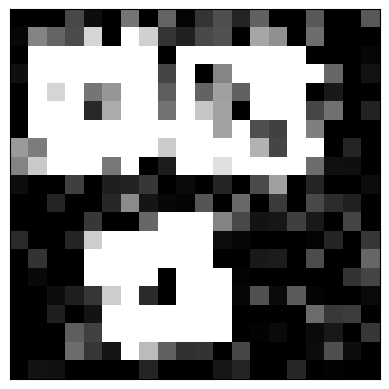

In [4]:
# テストデータ
show_image(X_test[10])

* 訓練データはノイズがない
* テストデータはノイズがあり、荒いデータとなっている

## データセットの作成
YOLOで転移学習を行うにあたって、データセットを作成する必要がある。今回はopencvを用いて作成してみる

In [5]:
# ライブラリのインポート
import cv2

### 描画してみる

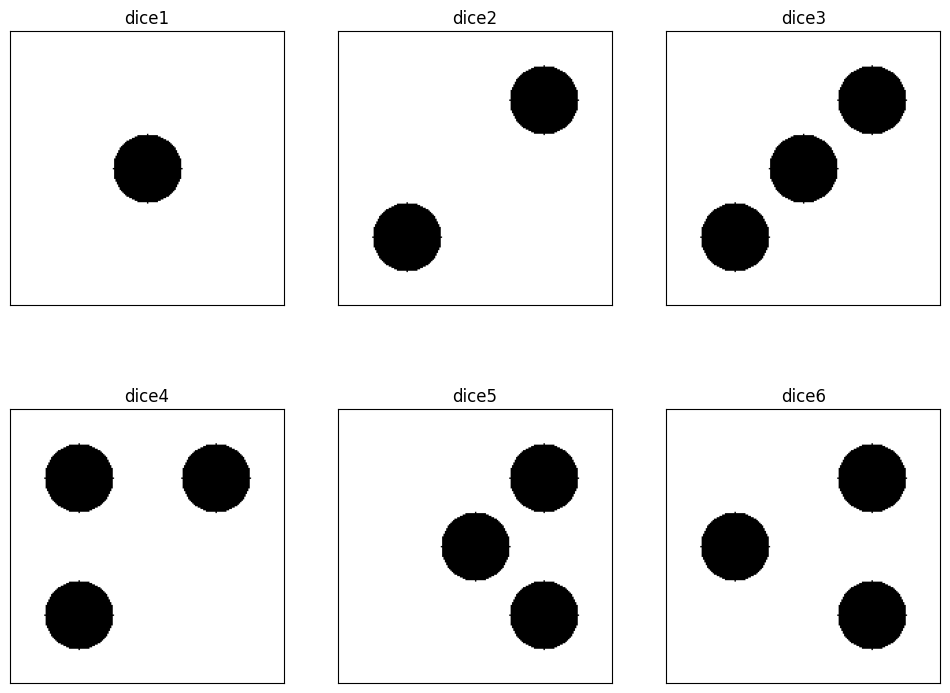

In [6]:
# サイコロを作成する関数
from util.make_datasets import make_dice

fig, axes = plt.subplots(2, 3, figsize=(12, 9))
dices = [] # ダイスの配列を格納する

for i, ax in enumerate(axes.ravel()):
    num = i + 1 # サイコロの目
    dice = make_dice(num)
    dices.append(dice)
    ax.imshow(dice, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"dice{num}")

無事にサイコロが作成できたので、これを活用してYOLOで学習を行うためのデータセットを作成してみる \
datasets/dicesの中にサイコロの画像を保存しておく。

In [7]:
# 保存先のパス
from conf import DATASET_PATH
DICE_DIR = os.path.join(DATASET_PATH, "dices")

# サイコロの画像(バイナリファイル)を保存
for i in range(1, 7):
    dice = make_dice(i)
    path = os.path.join(DICE_DIR, f"dice_{i}.npy")
    np.save(path, dice)

<h3>データセットを作成する関数の動作確認</h3>
make_dataset関数は戻り値が二つ存在する。<br>
<span style="color: red;">(500x500)の画像データ</span>と、<span style="color: blue;">YOLOで学習を行うためのラベル(.txt)</span>の二つである。

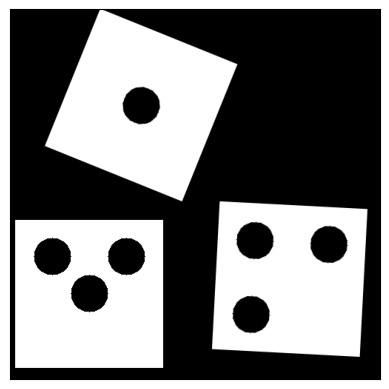

In [19]:
from util.make_datasets import make_dataset

# 動作確認

# 画像データ
data, labels = make_dataset((500, 500))
show_image(data)

In [20]:
# ラベル
labels

[['1', '0.355', '0.261', '0.522', '0.522'],
 ['4', '0.757', '0.731', '0.422', '0.422'],
 ['5', '0.215', '0.769', '0.402', '0.402']]

YOLOで想定されているラベルは、上記のような

<b>["class_label", "x_center", "y_center", "width", "height"]</b>

である。ここで、<b>右上が(0, 0)で右下が(1, 1)の想定である</b>ことに注意する。またピクセル数ではなく、割合で表していることにも注意する。

### データセットが正しく作成できるか動作確認を行う

In [9]:
# ライブラリのインポート
from util.make_datasets import generate_datasets # (20, 20)へリサイズ処理を行いデータを指定パスに保存する関数
from conf import DATASET_PATH, YOLO_DATASET_PATH

In [10]:
# 保存を行っているパス
MY_DATASET_PATH = os.path.join(DATASET_PATH, "my_datasets")
YOLO_TRAIN = os.path.join(YOLO_DATASET_PATH, "train")
YOLO_VAL = os.path.join(YOLO_DATASET_PATH, "val")

# 指定の数だけデータセットを生成
generate_datasets(dataset_num=1024, save_path=YOLO_TRAIN) # 訓練データ 1024枚
generate_datasets(dataset_num=256, save_path=YOLO_VAL) # 検証データ 256枚

(20, 20, 3)


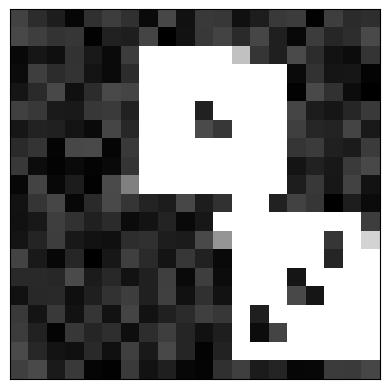

In [13]:
# 正しくデータが生成できているか確認
data = cv2.imread(os.path.join(YOLO_TRAIN, "images/image_0.png"))
print(data.shape)
show_image(data)

正しくデータセットが作成できているので、これを用いてYOLOでtrainingを行っていく